In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
import numpy as np
from sklearn import preprocessing

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

enc = preprocessing.OneHotEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()

print (x_train.shape)
print (y_train)
print (x_test.shape)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
(50000, 32, 32, 3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(10000, 32, 32, 3)


In [2]:
from tensorflow.keras.models import load_model

feature_extractor = load_model('extractor.h5')
feature_encoder = load_model('ae-encoder.h5')
print ("Models loaded!")

Models loaded!


In [3]:
features = feature_extractor.predict(x_train)
print (features.shape)

(50000, 10)


In [4]:
vectors = feature_encoder.predict(features)
print (vectors.shape)

(50000, 32)


In [5]:
import pickle

pickle_out = open("cbir-resnet-vectors.pickle", "wb")
pickle.dump(vectors, pickle_out)
pickle_out.close()

In [6]:

print (features[1])
print (vectors[1])

[3.0241949e-07 1.4418439e-06 1.0318051e-06 1.1050157e-07 6.2237238e-09
 1.3371290e-07 8.0894345e-08 5.8456055e-07 1.6888634e-07 9.9999619e-01]
[0.0000000e+00 3.2036448e-01 2.0205348e+00 1.4411324e-01 4.9759224e-01
 0.0000000e+00 4.9990731e-01 5.3557585e-04 1.0022901e+00 7.7502888e-01
 0.0000000e+00 1.1909435e-02 1.0423036e+00 1.0394855e+00 0.0000000e+00
 2.0961509e+00 4.6397585e-01 1.0240324e-01 0.0000000e+00 0.0000000e+00
 1.4129544e+00 0.0000000e+00 0.0000000e+00 1.2338827e+00 2.3502011e+00
 3.7409821e-01 0.0000000e+00 3.1557515e+00 1.7390196e+00 1.2509484e+00
 1.8111601e+00 1.7366786e+00]


In [7]:
import numpy as np
from annoy import AnnoyIndex

index = AnnoyIndex(vectors.shape[1])
for i in range(vectors.shape[0]):
    index.add_item(i, vectors[i,:].tolist())

/home/softdev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  after removing the cwd from sys.path.


In [8]:
index.build(20)
index.save("index.ann")

True

In [9]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(y_train.shape)
print(y_train[:, :].shape)
lookup = np.argmax(y_train[:, :], axis=1)

(50000, 10)
(50000, 10)


Querying with this random image


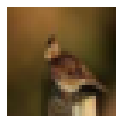

bird


In [10]:
import random
choice_idx = random.randrange(50000)
results = index.get_nns_by_item(choice_idx, 6000)

print ("Querying with this random image")

import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))
plt.imshow(x_train[choice_idx])
plt.axis('off')
plt.show()
print (labels[lookup[choice_idx]])
# print (lookup[choice_idx])

Search results:


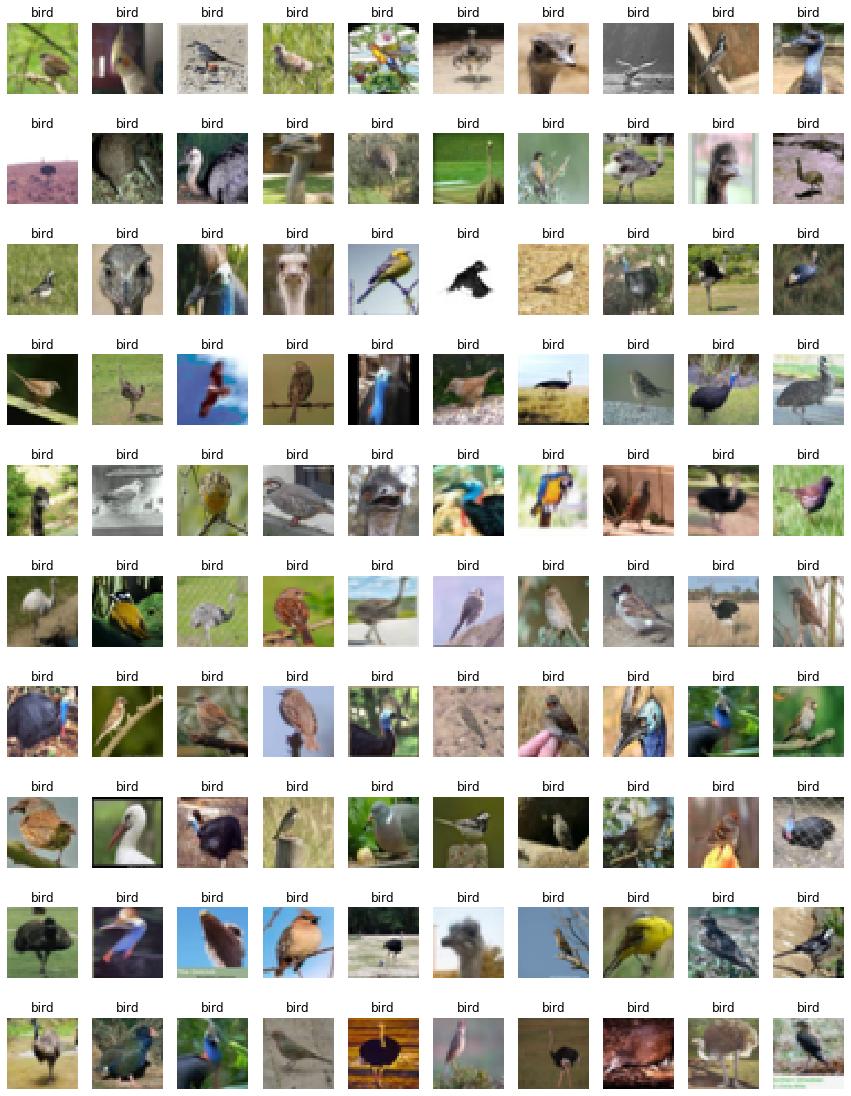

In [11]:
import matplotlib.pyplot as plt


print ("Search results:")

w=10
h=10
fig=plt.figure(figsize=(15,20))
columns = 10
rows = 10
for i in range(100):
#     ax = plt.subplot(5, 100, i+1)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_train[results[i]])
    plt.title(str(labels[lookup[results[i]]]))
    plt.axis('off')
plt.show()

In [12]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
t = np.ones(6000).astype(float)
p = np.array([lookup[x] == lookup[choice_idx] for x in results]).astype(float)

print ("F1 Score for this search:", f1_score(t, p))
print ("Accuracy Score for this search:", accuracy_score(t, p))
print ("Precision Score for this search:", precision_score(t, p))
print ("Recall Score for this search:", recall_score(t, p))

F1 Score for this search: 0.9084955430234674
Accuracy Score for this search: 0.8323333333333334
Precision Score for this search: 1.0
Recall Score for this search: 0.8323333333333334
